In [ ]:
!pip install pysal
!pip install scikit-learn --upgrade
!pip install scikit-gstat

import skgstat as skg
import seaborn as sns
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from libpysal.weights.util import min_threshold_distance
from pysal.lib import cg as geometry
from pysal.viz import splot
from pysal.explore import esda
from pysal.lib import weights
from splot import esda as esdaplot
from shapely import wkt
from shapely.geometry import Point


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 38.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.4/132.4 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.3/141.3 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.8/277.8 kB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 331.8/331.8 kB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 87.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/spaghetti/network.py:42: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)


In [ ]:
housing_df = pd.read_csv('https://raw.githubusercontent.com/MarkMData/Dissertation-data/main/cali_housing_lag_vars.csv')
# Create a GeoDataFrame
geometry = [Point(xy) for xy in zip(housing_df['longitude'], housing_df['latitude'])]
housing_gdf = gpd.GeoDataFrame(housing_df, geometry=geometry)
housing_gdf = housing_gdf.set_crs(epsg=4326)
housing_gdf = housing_gdf.to_crs(3857)
# getting xy coords
x = housing_gdf.geometry.centroid.x
y = housing_gdf.geometry.centroid.y
housing_df['x'] = x
housing_df['y'] = y
coords = np.column_stack((x,y))

### Calculating Moran's I for a range of distance bands

In [ ]:
def moran_function(distances, target):
    moran_i = []
    moran_p = []
    islands = []
    max_neigh = []
    min_neigh = []
    mean_neigh = []
    for i in range(len(distances)):
        w_distance = weights.distance.DistanceBand.from_dataframe(
        housing_gdf, distances[i], binary=True, silence_warnings = True)
        moran = esda.moran.Moran(housing_gdf[target], w_distance)
        moran_i.append(round(moran.I,3))
        moran_p.append(round(moran.p_sim,3))
        islands.append(len(w_distance.islands))
        max_neigh.append(w_distance.max_neighbors)
        min_neigh.append(w_distance.min_neighbors)
        mean_neigh.append(w_distance.mean_neighbors)

    moran_df = pd.DataFrame({'distance': distances,
                             'morans_I':moran_i,
                             'p_value': moran_p,
                             'n_islands': islands,
                            'max_neigh': max_neigh,
                            'min_neigh': min_neigh,
                            'mean_neigh': mean_neigh})
    return moran_df

In [ ]:
###############################################################################
# NOTE THIS REQUIRES A HIGH RAM RUNTIME USE CODE IN CELL BELOW TO SKIP AND LOAD
# THE RESULTS DATAFRAME FROM A CSV FILE
###############################################################################

# Morans I for log_medianHouseValue
distances = [2500, 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000, 50000]
target = 'log_medianHouseValue'
moran_log_medianHouseValue_df = moran_function(distances, target)
moran_log_medianHouseValue_df

,distance,morans_I,p_value,n_islands,max_neigh,min_neigh,mean_neigh
0,2500,0.789,0.001,2507,87,0,16.182171
1,5000,0.728,0.001,1111,309,0,68.652810
2,10000,0.653,0.001,457,862,0,228.380620
3,15000,0.597,0.001,248,1667,0,441.902810
4,20000,0.554,0.001,139,2461,0,690.360271
5,25000,0.523,0.001,73,3365,0,985.772481
6,30000,0.500,0.001,49,4284,0,1292.105814
7,35000,0.482,0.001,30,5031,0,1603.571415
8,40000,0.473,0.001,20,5611,0,1900.424322
9,45000,0.466,0.001,14,6121,0,2186.052616


In [ ]:
moran_log_medianHouseValue_df = pd.read_csv('https://raw.githubusercontent.com/MarkMData/Dissertation-data/main/moran_log_medianHouseValue_df.csv')
moran_log_medianHouseValue_df

,distance,morans_I,p_value,n_islands,max_neigh,min_neigh,mean_neigh
0,2500,0.789,0.001,2507,87,0,16.182171
1,5000,0.728,0.001,1111,309,0,68.652810
2,10000,0.653,0.001,457,862,0,228.380620
3,15000,0.597,0.001,248,1667,0,441.902810
4,20000,0.554,0.001,139,2461,0,690.360271
5,25000,0.523,0.001,73,3365,0,985.772481
6,30000,0.500,0.001,49,4284,0,1292.105814
7,35000,0.482,0.001,30,5031,0,1603.571415
8,40000,0.473,0.001,20,5611,0,1900.424322
9,45000,0.466,0.001,14,6121,0,2186.052616


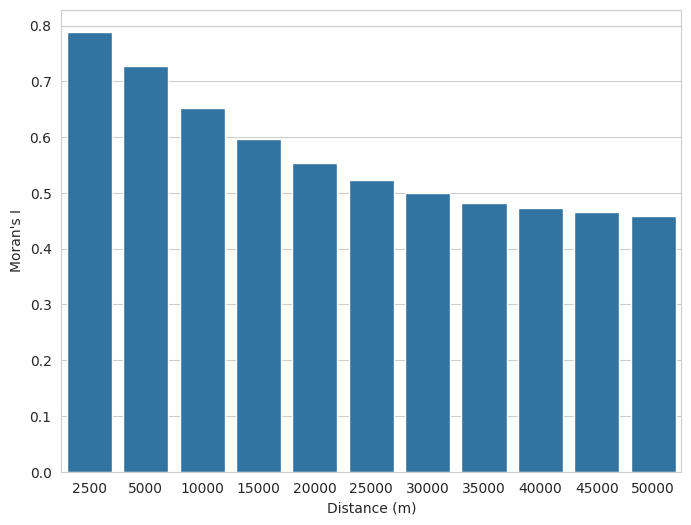

In [ ]:
# Create barplot of Moran's I values for the range of distances
plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")

sns.barplot(x='distance', y='morans_I', data=moran_log_medianHouseValue_df)
plt.xlabel('Distance (m)')
plt.ylabel('Moran\'s I')
plt.show()

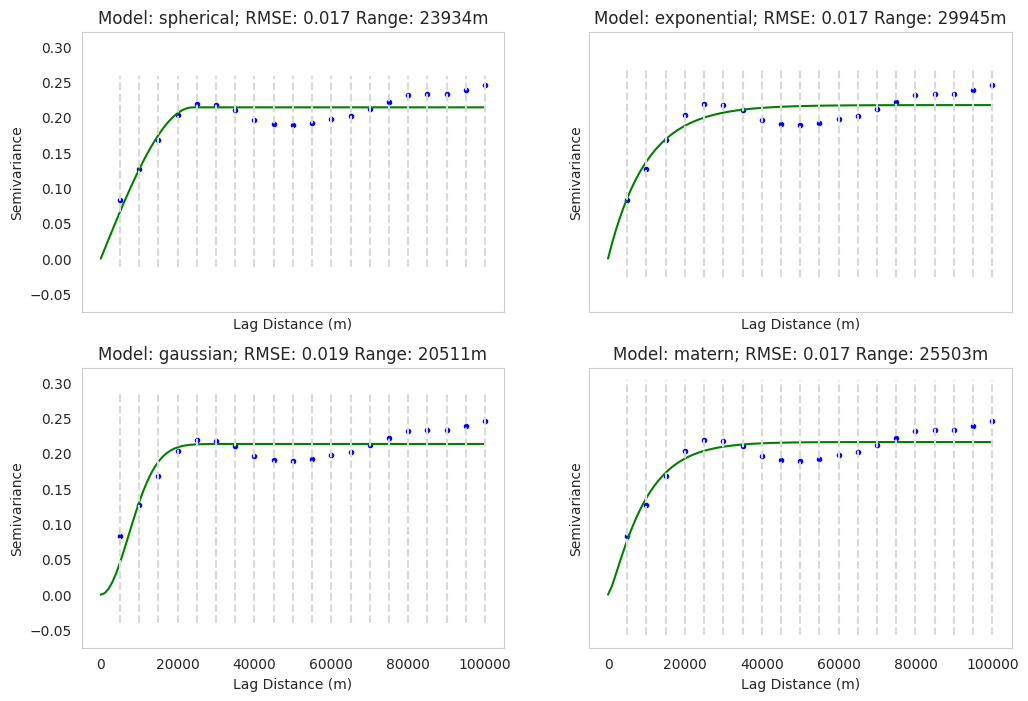

In [ ]:
# creating variogram for the response
target = housing_df['log_medianHouseValue']
V = skg.Variogram(coords, target, normalize=False, model='spherical', maxlag = 100000, n_lags = 20)
# Finding variogram with best rmse
fig, _a = plt.subplots(2,2, figsize=(12, 8), sharex=True, sharey=True)
axes = _a.flatten()
for i, model in enumerate(('spherical', 'exponential', 'gaussian', 'matern')):
    V.model = model
    V.plot(axes=axes[i], hist=False, show=False)
    axes[i].set_title('Model: %s; RMSE: %.3f Range: %.0fm' % (model, V.rmse, V.parameters[0]))
    # Set custom axis labels
    axes[i].set_xlabel('Lag Distance (m)')
    axes[i].set_ylabel('Semivariance')

# Spatial autocorrelation of residuals

In [ ]:
###############################################################################
# THIS TAKES A WHILE AND CAN BE SKIPPED BY LOADING THE CSV FILE IN TH CELL BELLOW
###############################################################################

### Load csv files with residuals and calculate morans I for 5km, 20km, and 50km distances
model_names = ['random_lag20_predictors',
  'random_lag20_response',
  'random_lag5_predictors',
  'random_lag5_response',
  'random_no_lag',
  'spatial_buff_lag20_predictors',
  'spatial_buff_lag20_response',
  'spatial_buff_lag5_predictors',
  'spatial_buff_lag5_response',
  'spatial_lag20_predictors',
  'spatial_lag20_response',
  'spatial_lag5_predictors',
  'spatial_lag5_response',
  'spatial_no_lag']
# df to store morans i for each model across 3 distances
moran_residuals = pd.DataFrame()
for i in range(len(model_names)):
    model_name = model_names[i]
    df = pd.read_csv('https://raw.githubusercontent.com/MarkMData/Dissertation-data/main/cali_results/'+model_name+'_predictions.csv')
    # Create a GeoDataFrame
    geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
    gdf = gpd.GeoDataFrame(df, geometry=geometry)
    gdf = gdf.set_crs(epsg=4326)
    gdf = gdf.to_crs(3857)
    # getting morans i for a range of distances
    distances = [5000, 20000, 50000]
    moran_i = []
    p_sim = []
    for j in range(len(distances)):
        w_distance = weights.distance.DistanceBand.from_dataframe(
        gdf, distances[j], binary=True, silence_warnings = True)
        moran = esda.moran.Moran(gdf['residuals'], w_distance)
        moran_i.append(round(moran.I,3))
        p_sim.append(round(moran.p_sim,3))
    # save morans i and sim p for each distance
    moran_df = pd.DataFrame({'model':[model_name],
                            'Moran_5km': [moran_i[0]],
                            'p_sim_5km': [p_sim[0]],
                            'Moran_20km': [moran_i[1]],
                            'p_sim_20km': [p_sim[1]],
                            'Moran_50km': [moran_i[2]],
                            'p_sim_50km': [p_sim[2]],})
    moran_residuals = pd.concat([moran_residuals, moran_df], ignore_index=True)
moran_residuals

,model,Moran_5km,p_sim_5km,Moran_20km,p_sim_20km,Moran_50km,p_sim_50km
0,random_lag20_predictors,0.533,0.001,0.379,0.001,0.277,0.001
1,random_lag20_response,0.328,0.001,0.137,0.001,0.111,0.001
2,random_lag5_predictors,0.405,0.001,0.290,0.001,0.198,0.001
3,random_lag5_response,0.064,0.001,0.094,0.001,0.072,0.001
4,random_no_lag,0.390,0.001,0.339,0.001,0.280,0.001
5,spatial_buff_lag20_predictors,0.521,0.001,0.365,0.001,0.252,0.001
6,spatial_buff_lag20_response,0.334,0.001,0.144,0.001,0.114,0.001
7,spatial_buff_lag5_predictors,0.403,0.001,0.287,0.001,0.194,0.001
8,spatial_buff_lag5_response,0.064,0.001,0.094,0.001,0.072,0.001
9,spatial_lag20_predictors,0.517,0.001,0.362,0.001,0.252,0.001


In [ ]:
# Loading data from above
moran_residuals= pd.read_csv('https://raw.githubusercontent.com/MarkMData/Dissertation-data/main/cali_results/moran_residuals.csv')
moran_residuals

### Plotting Moran's I for the residuals

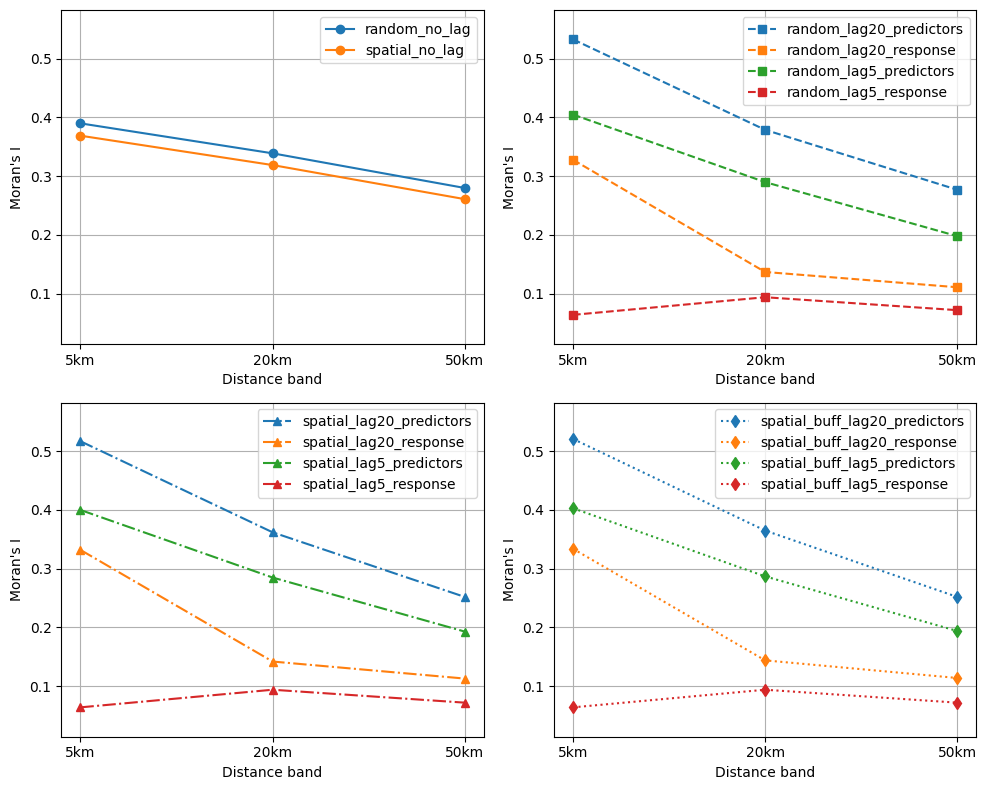

In [ ]:
# Load the data
df = pd.read_csv('https://raw.githubusercontent.com/MarkMData/Dissertation-data/main/cali_results/moran_residuals.csv')

# Define the model categories
categories = {
    'Random No Lag & Spatial No Lag': ['random_no_lag', 'spatial_no_lag'],
    'Random Lag': ['random_lag20_predictors', 'random_lag20_response', 'random_lag5_predictors', 'random_lag5_response'],
    'Spatial Lag': ['spatial_lag20_predictors', 'spatial_lag20_response', 'spatial_lag5_predictors', 'spatial_lag5_response'],
    'Spatial Buff Lag': ['spatial_buff_lag20_predictors', 'spatial_buff_lag20_response', 'spatial_buff_lag5_predictors', 'spatial_buff_lag5_response']
}

# Define the plot styles for each category
styles = {
    'Random No Lag & Spatial No Lag': {'marker': 'o', 'linestyle': '-'},
    'Random Lag': {'marker': 's', 'linestyle': '--'},
    'Spatial Lag': {'marker': '^', 'linestyle': '-.'},
    'Spatial Buff Lag': {'marker': 'd', 'linestyle': ':'}
}

# Determine the global min and max values for Moran's I
y_min = df[['Moran_5km', 'Moran_20km', 'Moran_50km']].min().min() - 0.05
y_max = df[['Moran_5km', 'Moran_20km', 'Moran_50km']].max().max() + 0.05

# Color palette from seaborn
palette = sns.color_palette("tab10", len(df))

# Create the subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

# Plot each category in a separate subplot
for ax, (category, models) in zip(axes, categories.items()):
    for i, model in enumerate(models):
        row = df[df['model'] == model].iloc[0]
        distances = ['5km', '20km', '50km']
        moran_values = [row['Moran_5km'], row['Moran_20km'], row['Moran_50km']]
        style = styles[category]
        color = palette[i % len(palette)]
        ax.plot(distances, moran_values, marker=style['marker'], linestyle=style['linestyle'], color=color, label=model)

    ax.set_ylim([y_min, y_max])
    ax.set_title('')
    ax.set_xlabel('Distance band')
    ax.set_ylabel("Moran's I")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()